## Tarefa Bonus 2 - Implementação KNN 

Caio Martim Barros - 472713

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 

In [95]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
print(f"df_train.shape: {df_train.shape}\ndf_test.shape: {df_test.shape}")

df_train.shape: (891, 12)
df_test.shape: (418, 11)


In [96]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [97]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [98]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [99]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [100]:
df_train["Age"].fillna(df_train["Age"].median(), inplace = True)

### 5. Selecionar as features baseada na correlação (tip: pandas)

C:\Users\caio_barros\AppData\Local\Temp\ipykernel_23100\1936342947.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train.corr(),cmap = 'RdBu',cbar = True,annot = True)


<Axes: >

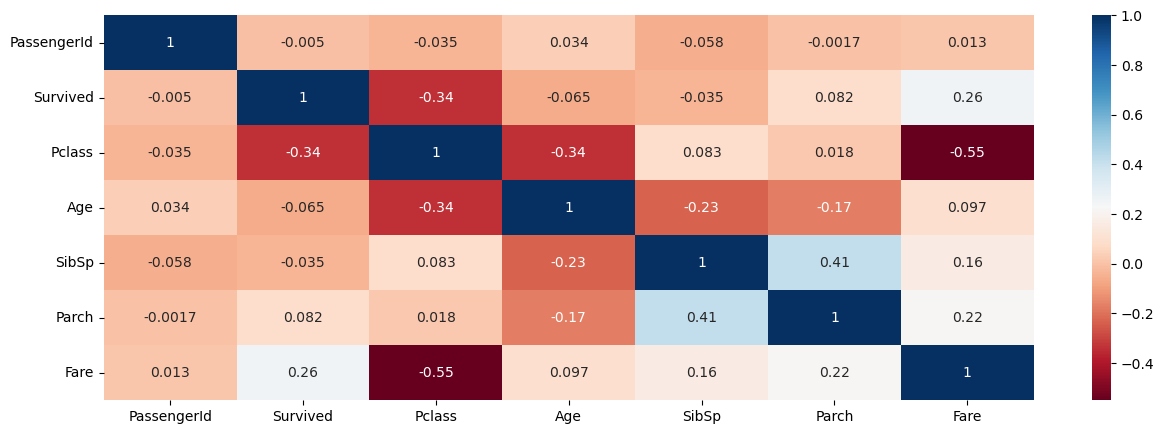

In [101]:
plt.subplots(figsize = (15,5))
sns.heatmap(df_train.corr(),cmap = 'RdBu',cbar = True,annot = True)

Dessa forma, pensando fora da matriz de correlação, já que o único valor alto que podemos analisar seria Pclass x Fare, podemos retirar algumas colunas antes da nossa criação do modelo kNN, por inferência, dentre eles estão:

- Existem três tipos de classe bilhete e a cabine numero pode estar diretamente relacionado com o tipo de classe bilhete correspondente. Como existem muitos números de cabine, é mais fácil se basear pela classe bilhete do que pelo número e dessa forma a coluna cabine_numero será descartada também da análise.
- Da mesma forma, o numero do bilhete está relacionado com a cabine e por consequência da remoção do último, esse também será removido.
- Sobre o local embarque, ele é inconclusivo e portanto ele será mantido para fazermos análises mais precisas sobre a relevância no contexto de sobrevivência.
- PassengerId é só um identificador e ele não vai impactar, da mesma forma, o nome da pessoa Name também não.

In [102]:
df_train.drop(columns = ["PassengerId", "Cabin", "Name", "Ticket", "Fare"], inplace = True)

### 3. Transformar as features categóricas em numéricas (tip: pandas ou scikit-learn)

In [103]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Embarked  889 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 48.9+ KB


In [104]:
cat_features = ["Sex", "Embarked"]
df_cat = df_train[cat_features]
df_cat

,Sex,Embarked
0,male,S
1,female,C
2,female,S
3,female,S
4,male,S
...,...,...
886,male,S
887,female,S
888,female,S
889,male,C


In [105]:
le = LabelEncoder()

In [106]:
for categorical in cat_features:
    df_train[categorical] = le.fit_transform(df_train[categorical])

In [107]:
df_cat = df_train[cat_features]
df_cat

,Sex,Embarked
0,1,2
1,0,0
2,0,2
3,0,2
4,1,2
...,...,...
886,1,2
887,0,2
888,0,2
889,1,0


### 4. Analisar a necessidade de normalizar as features numéricas (tip: pandas ou scikit-learn)

In [108]:
df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,1,22.0,1,0,2
1,1,1,0,38.0,1,0,0
2,1,3,0,26.0,0,0,2
3,1,1,0,35.0,1,0,2
4,0,3,1,35.0,0,0,2
...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,2
887,1,1,0,19.0,0,0,2
888,0,3,0,28.0,1,2,2
889,1,1,1,26.0,0,0,0


Precisamos utilizar o StandardScaler, apesar da maioria das colunas estarem em unidades parecidas, kNN é importante normalizar. Vale lembrar que é bom fazer a normalização somente para train e não pro teste, pois os dados são sensíveis. Portanto, na etapa de utilizacao do KNN, iremos normalizar os dados.

### 6. Separar o dataset em treino (75%) / teste (25%) / validação (10% do treino)

In [109]:
X = df_train.drop("Survived", axis = 1, inplace = False)
y = df_train["Survived"]

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [111]:
print(f"X_train: {X_train.shape}\nX_test: {X_test.shape}\ny_train: {y_train.shape}\ny_test: {y_test.shape}")

X_train: (668, 6)
X_test: (223, 6)
y_train: (668,)
y_test: (223,)


In [112]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [115]:
print(f"X_train: {X_train.shape}\nX_val: {X_val.shape}\ny_train: {y_train.shape}\ny_test: {y_test.shape}\nX_val: {X_val.shape}\ny_val: {y_val.shape}")

X_train: (601, 6)
X_val: (67, 6)
y_train: (601,)
y_test: (223,)
X_val: (67, 6)
y_val: (67,)


In [20]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)
X_val_norm = scaler.transform(X_val)

### 1. Implementar uma função que selecione os k vizinhos mais próximos (k > 1)

In [57]:
def knn_method(X_train, y_train, X_test, k):
    if k > 1:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        return y_pred
    else:
        return "k needs to be higher than 1"

In [71]:
y_pred = knn_method(X_train_norm, y_train, X_test_norm, k=5)
print(f"accuracy: {round(accuracy_score(y_test, y_pred), 2)}")

accuracy: 0.78


### 2. Implementar uma função que recebe os k vizinhos mais próximos e determinar a classe correta

In [59]:
def knn_method_df(X_train, y_train, X_test, y_test, k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    df = pd.DataFrame({"y_test": y_test, "y_pred": y_pred})
    return df

In [60]:
knn_method_df(X_train_norm, y_train, X_test_norm, y_test, k=5)

,y_test,y_pred
709,1,0
439,0,0
840,0,0
720,1,1
39,1,0
...,...,...
880,1,1
425,0,0
101,0,0
199,0,1


### 7. Execute o classificador para 30 k's pulando de 4 em 4 e apresente todas as acurácias utilizando o dataset de validação (Qual o melhor k?) [plotar um gráfico com os resultados]

In [75]:
k_values = np.arange(4, 31, 4)

acc = []
for k in k_values:
    y_pred = knn_method(X_train_norm, y_train, X_val_norm, k=k)
    accuracy = accuracy_score(y_val, y_pred)
    acc.append(accuracy)

# best k_value
best_k = k_values[np.argmax(acc)]
print(f"Best k value: {best_k}")
print(f"Accuracy for best_k ({best_k}) is: {round(max(acc) * 100, 2)}%")

Best k value: 12
Accuracy for best_k (12) is: 85.07%


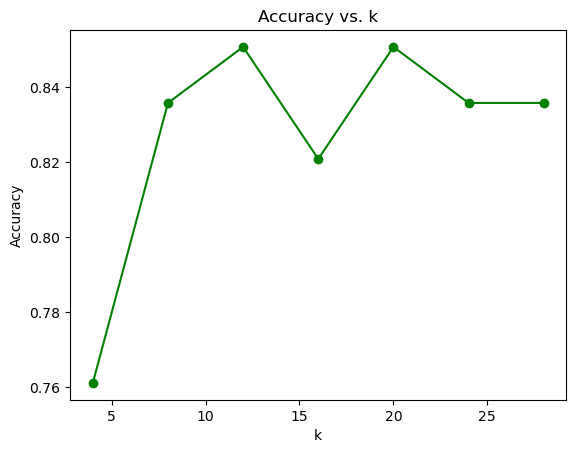

In [80]:
plt.plot(k_values, acc, 'go-')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k')
plt.show()

### 8. Executar o classificador para o melhor k encontrado utilizando o dataset de teste e apresentar um relatório da precisão (tip: scikit-learn) [plotar um gráfico com os resultados]

In [82]:
y_pred = knn_method(X_train_norm, y_train, X_test_norm, k=best_k)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       134
           1       0.80      0.69      0.74        89

    accuracy                           0.81       223
   macro avg       0.81      0.79      0.79       223
weighted avg       0.81      0.81      0.80       223



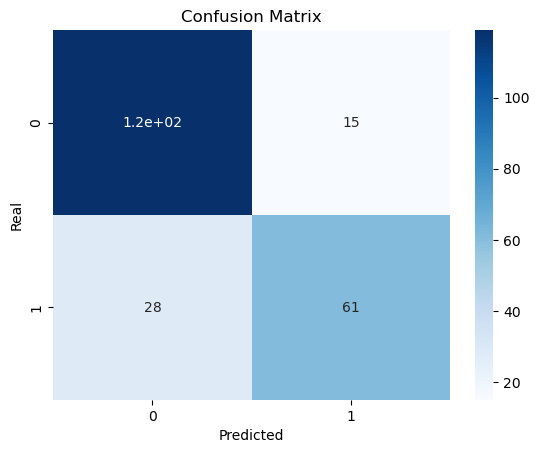

In [83]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()